In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

In [79]:
class prediction_model:

	def __init__(self, model, model2, filepath):

		self.end_prediction = model
		self.open_prediction = model2
		self.path = filepath

		data = self.translate_data(filepath)

		self.end_prediction_data, self.end_names = self.build_training(data, 'Close/Last')
		self.open_prediction_data, self.open_names = self.build_training(data, 'Open')

		print(self.end_prediction_data)
		print(self.open_prediction_data)

		end_X = self.end_prediction_data.drop(columns=['High', 'Low', 'Volume', 'Close/Last', 'Date'] , axis=1)
		end_y = self.end_prediction_data['Close/Last']

		open_X = self.open_prediction_data.drop(columns=['High', 'Low', 'Volume', 'Open', 'Date'] , axis=1)
		open_y = self.open_prediction_data['Open'].shift(-1)

		self.end_X_train, self.end_X_test, self.end_y_train, self.end_y_test = train_test_split(end_X, end_y, test_size=0.2, shuffle=False, random_state=0)
		self.open_X_train, self.open_X_test, self.open_y_train, self.open_y_test = train_test_split(open_X, open_y, test_size=0.2, shuffle=False, random_state=0)

######
####
##		Helper Functions to handle initiation of the model
#
###
##	Heloper function to ensure that the data is from nasdaq.com
#
	def ensure_nasdaq(self, df):
		##check headdings are correct:
		if 'Date' not in df.columns:
			raise ValueError("The data does not contain the Date column.")

		if 'Open' not in df.columns:
			raise ValueError("The data does not contain the Open column.")
		
		if 'Close/Last' not in df.columns:
			raise ValueError("The data does not contain the Close column.")
			
		if 'High' not in df.columns:
			raise ValueError("The data does not contain the High column.")
		
		if 'Low' not in df.columns:
			raise ValueError("The data does not contain the Low column.")

		if 'Volume' not in df.columns:
			raise ValueError("The data does not contain the Volume column.")
		
		print("Data is in the correct format and likely origins from nasdaq.com")

		return True
###
##	Helper function to translate the data to the correct format for analysis
#
	def translate_data(self, path):
		data = pd.read_csv(path)
		# Ensure that the data is from nasdaq.com
	
		if(not self.ensure_nasdaq(data)):
			raise ValueError("The data is not from nasdaq.com. Please provide data from nasdaq.com")


		# Translate the data and remove $ from the data and multiply close, open, high and low by a factor of 100 and convert them to integers
		data['Date'] = pd.to_datetime(data['Date'])
		data['Close/Last'] = data['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
		data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
		data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
		data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)


		# inverse the entire dataframe
		data = data.iloc[::-1]

		# reset the index
		data = data.reset_index(drop=True)

		return data
###
##	Helper function to build the training data from the raw data
#
	def build_training(self, origindf, column):
		lags = 5
		names = []

		df = origindf.copy()

		for i in range(1, lags+1):
			df[f'{column}_{i}'] = df[column].shift(i)

			names.append(f'{column}_{i}')

		df.dropna(inplace=True)

		return df, names
###
##	Helper function to create the columns for the lags
#
	def create_lags(self, df, column, buffer, lags=5):
		
		lag = lags
		names = []

		for i in range(1, lag+1):
			df[f'{column}_{i}'] = []
			names.append(f'{column}_{i}')

		return names
###
##	Helper function to build the test data from the raw data
#
	def build_lags(self, df, column, buffer,row=0, lags=5):
		
		lag = lags

		print("building row: ", row, " for column: ", column)

		if row == 0:
			for i in range(1, lag+1):
				df.loc[row, f'{column}_{i}'] = buffer[(lag-i)]

		else:
			if row > lags:
				for i in range(1, lag+1):
					df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]

			else:
				for i in range(1, lag+1):

					if i <= row:
						df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]
					else:
						df.loc[row, f'{column}_{i}'] = df.loc[row-1, f'{column}_{i-1}']
			
		

		return df
#
##		End of Helper Functions
####
######


######
####
##		Class method to train the model
#
	def train_model(self):

		print(self.end_X_train)
		print(self.open_X_train)

		# Fit the model
		self.end_prediction.fit(self.end_X_train, self.end_y_train)
		self.open_prediction.fit(self.open_X_train, self.open_y_train)

		return True

######
####
##		Class method to predict the test data
#
	def predict(self, days=7):


		### setup
		predictions_output = pd.DataFrame()

		## Lag buffer setup
		lag_buffer = 5
		end_lag_buffer = self.end_X_train['Open'][len(self.end_X_train['Open'])-lag_buffer:]
		open_lag_buffer = self.open_X_train['Close/Last'][len(self.open_X_train['Close/Last'])-lag_buffer:]
		##reset the index of the lag buffers
		end_lag_buffer = end_lag_buffer.reset_index(drop=True)
		open_lag_buffer = open_lag_buffer.reset_index(drop=True)

		## create the columns for the predictions_output
		predictions_output['Date'] = pd.to_datetime([])
		predictions_output['Open'] = []
		open_names = self.create_lags(predictions_output, 'Open', end_lag_buffer, lag_buffer)
		predictions_output['Close/Last'] = []
		close_names = self.create_lags(predictions_output, 'Close/Last', open_lag_buffer, lag_buffer)




		### create the first row of the dataframe
		# get the next date from the last date in the training data
		last_date = self.end_prediction_data['Date'][len(self.end_y_train)]
		next_date = last_date + pd.DateOffset(days=1)

		predictions_output.loc[0, 'Date'] = next_date

		##get the last row of the dataframe from open_X_train
		last_row = self.open_X_train.iloc[-1]
		## turn into a sample instead of a series
		last_rows = last_row.to_frame().T




		open_prediction = self.open_prediction.predict(last_rows)
		predictions_output.loc[0, 'Open'] = open_prediction[-1]


		self.build_lags(predictions_output, 'Open', end_lag_buffer, 0, lag_buffer)
		self.build_lags(predictions_output, 'Close/Last', open_lag_buffer, 0, lag_buffer)

		end_predictions = self.end_prediction.predict(predictions_output[['Open'] + close_names])

		predictions_output.loc[0, 'Close/Last'] = end_predictions[-1]


		## loop through the days
  
		for i in range(1, days):
			
			## get the next date
			next_date = next_date + pd.DateOffset(days=1)

			## add the date to the dataframe
			predictions_output.loc[i, 'Date'] = next_date

			## get the last row of the dataframe
			last_row = predictions_output.iloc[-1]
			## get the open prediction
			open_prediction = self.open_prediction.predict(predictions_output[['Close/Last'] + open_names].iloc[-2].to_frame().T)

			## add the open prediction to the dataframe
			predictions_output.loc[i, 'Open'] = open_prediction

			self.build_lags(predictions_output, 'Open', end_lag_buffer, i, lag_buffer)
			self.build_lags(predictions_output, 'Close/Last', open_lag_buffer, i, lag_buffer)

			## get the close prediction
			end_predictions = self.end_prediction.predict(predictions_output[['Open'] + close_names])

			## add the close prediction to the dataframe
			predictions_output.loc[i, 'Close/Last'] = end_predictions[-1]


		self.preds = predictions_output


		return predictions_output
	
######
####
##		Class method to display the graphs of the predictions
#
	def graph(self):

		## create plot with 3 subplots
		fig, ax = plt.subplots(4, figsize=(25, 20))

		## plot the closes and open of training
		ax[0].plot(self.end_prediction_data['Date'][:len(self.end_y_train)], self.end_y_train, label='Training Close Price', color='blue')
		ax[0].plot(self.open_prediction_data['Date'][:len(self.open_y_train)], self.open_y_train, label='Training Open Price', color='green')
		

		## add title and legend
		ax[0].set_title('Close and Open Training Prices')
		ax[0].legend()


		## plot the predictions vs results

		print(self.end_prediction_data['Date'][len(self.end_y_train):len(self.end_y_train) + len(self.preds)].shape)
		print(self.end_y_test[:len(self.preds)].shape)

		ax[1].plot(self.end_prediction_data['Date'][len(self.end_y_train):len(self.end_y_train) + len(self.preds)], self.end_y_test[:len(self.preds)], label='Actual Test Close Price', color='yellow', linestyle='-.')
		ax[1].plot(self.end_prediction_data['Date'][len(self.end_y_train):len(self.end_y_train) + len(self.preds)], self.preds['Close/Last'], label='Predicted Test Close Price', color='blue', linestyle='-')

		ax[1].plot(self.open_prediction_data['Date'][len(self.open_y_train):len(self.open_y_train) + len(self.preds)], self.open_y_test[:len(self.preds)], label='Actual Test Open Price', color='blue', linestyle='-.')
		ax[1].plot(self.open_prediction_data['Date'][len(self.open_y_train):len(self.open_y_train) + len(self.preds)], self.preds['Open'], label='Predicted Test Open Price', color='yellow', linestyle='-')

		## add title and legend
		ax[1].set_title('Close and Open Predictions vs Results')
		ax[1].legend()


		plt.show()

In [80]:
prediction = prediction_model(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), "csvs/stocks/tsla/tsla.csv")

Data is in the correct format and likely origins from nasdaq.com
           Date  Close/Last     Volume      Open      High       Low  \
5    2014-05-01     21.1243  243835270   21.1429   21.2429   20.9414   
6    2014-05-02     21.1636  190692468   21.1550   21.2214   21.0611   
7    2014-05-05     21.4629  286095206   21.0764   21.4643   21.0714   
8    2014-05-06     21.2289  373872650   21.4929   21.5861   21.2289   
9    2014-05-07     21.1547  282128727   21.2589   21.3318   20.9904   
...         ...         ...        ...       ...       ...       ...   
2512 2024-04-17    168.0000   50901210  169.6100  170.6500  168.0000   
2513 2024-04-18    167.0400   43122900  168.0300  168.6400  166.5500   
2514 2024-04-19    165.0000   68149380  166.2100  166.4000  164.0750   
2515 2024-04-22    165.8400   48116440  165.5150  167.2600  164.7700   
2516 2024-04-23    166.9000   49537760  165.3500  167.0500  164.9200   

      Close/Last_1  Close/Last_2  Close/Last_3  Close/Last_4  Close/La

In [81]:
prediction.train_model()

          Open  Close/Last_1  Close/Last_2  Close/Last_3  Close/Last_4  \
5      21.1429       21.0747       21.1547       21.2175       20.4264   
6      21.1550       21.1243       21.0747       21.1547       21.2175   
7      21.0764       21.1636       21.1243       21.0747       21.1547   
8      21.4929       21.4629       21.1636       21.1243       21.0747   
9      21.2589       21.2289       21.4629       21.1636       21.1243   
...        ...           ...           ...           ...           ...   
2009  170.6200      170.4000      167.6600      165.7500      170.0900   
2010  163.9200      165.2900      170.4000      167.6600      165.7500   
2011  165.0200      165.0700      165.2900      170.4000      167.6600   
2012  168.7600      167.4000      165.0700      165.2900      170.4000   
2013  168.9100      167.2300      167.4000      165.0700      165.2900   

      Close/Last_5  
5          20.2775  
6          20.4264  
7          21.2175  
8          21.1547  
9     

True

In [82]:

prediction.predict(365)

building row:  0  for column:  Open
building row:  0  for column:  Close/Last
building row:  1  for column:  Open
building row:  1  for column:  Close/Last
building row:  2  for column:  Open
building row:  2  for column:  Close/Last
building row:  3  for column:  Open
building row:  3  for column:  Close/Last
building row:  4  for column:  Open
building row:  4  for column:  Close/Last
building row:  5  for column:  Open
building row:  5  for column:  Close/Last
building row:  6  for column:  Open
building row:  6  for column:  Close/Last
building row:  7  for column:  Open
building row:  7  for column:  Close/Last
building row:  8  for column:  Open
building row:  8  for column:  Close/Last
building row:  9  for column:  Open
building row:  9  for column:  Close/Last
building row:  10  for column:  Open
building row:  10  for column:  Close/Last
building row:  11  for column:  Open
building row:  11  for column:  Close/Last
building row:  12  for column:  Open
building row:  12  for 

,Date,Open,Open_1,Open_2,Open_3,Open_4,Open_5,Close/Last,Close/Last_1,Close/Last_2,Close/Last_3,Close/Last_4,Close/Last_5
0,2022-04-15,166.398222,168.910000,168.760000,165.020000,163.920000,170.620000,166.615752,166.420000,167.230000,167.400000,165.070000,165.290000
1,2022-04-16,166.660233,166.398222,168.910000,168.760000,165.020000,163.920000,166.811600,166.615752,166.420000,167.230000,167.400000,165.070000
2,2022-04-17,166.808767,166.660233,166.398222,168.910000,168.760000,165.020000,166.854196,166.811600,166.615752,166.420000,167.230000,167.400000
3,2022-04-18,166.949745,166.808767,166.660233,166.398222,168.910000,168.760000,167.016410,166.854196,166.811600,166.615752,166.420000,167.230000
4,2022-04-19,167.087616,166.949745,166.808767,166.660233,166.398222,168.910000,167.175098,167.016410,166.854196,166.811600,166.615752,166.420000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2023-04-10,227.269195,227.077739,226.886422,226.695242,226.504201,226.313298,227.376368,227.184836,226.993442,226.802186,226.611068,226.420089
361,2023-04-11,227.460789,227.269195,227.077739,226.886422,226.695242,226.504201,227.568038,227.376368,227.184836,226.993442,226.802186,226.611068
362,2023-04-12,227.652521,227.460789,227.269195,227.077739,226.886422,226.695242,227.759847,227.568038,227.376368,227.184836,226.993442,226.802186
363,2023-04-13,227.844392,227.652521,227.460789,227.269195,227.077739,226.886422,227.951795,227.759847,227.568038,227.376368,227.184836,226.993442


(365,)
(365,)


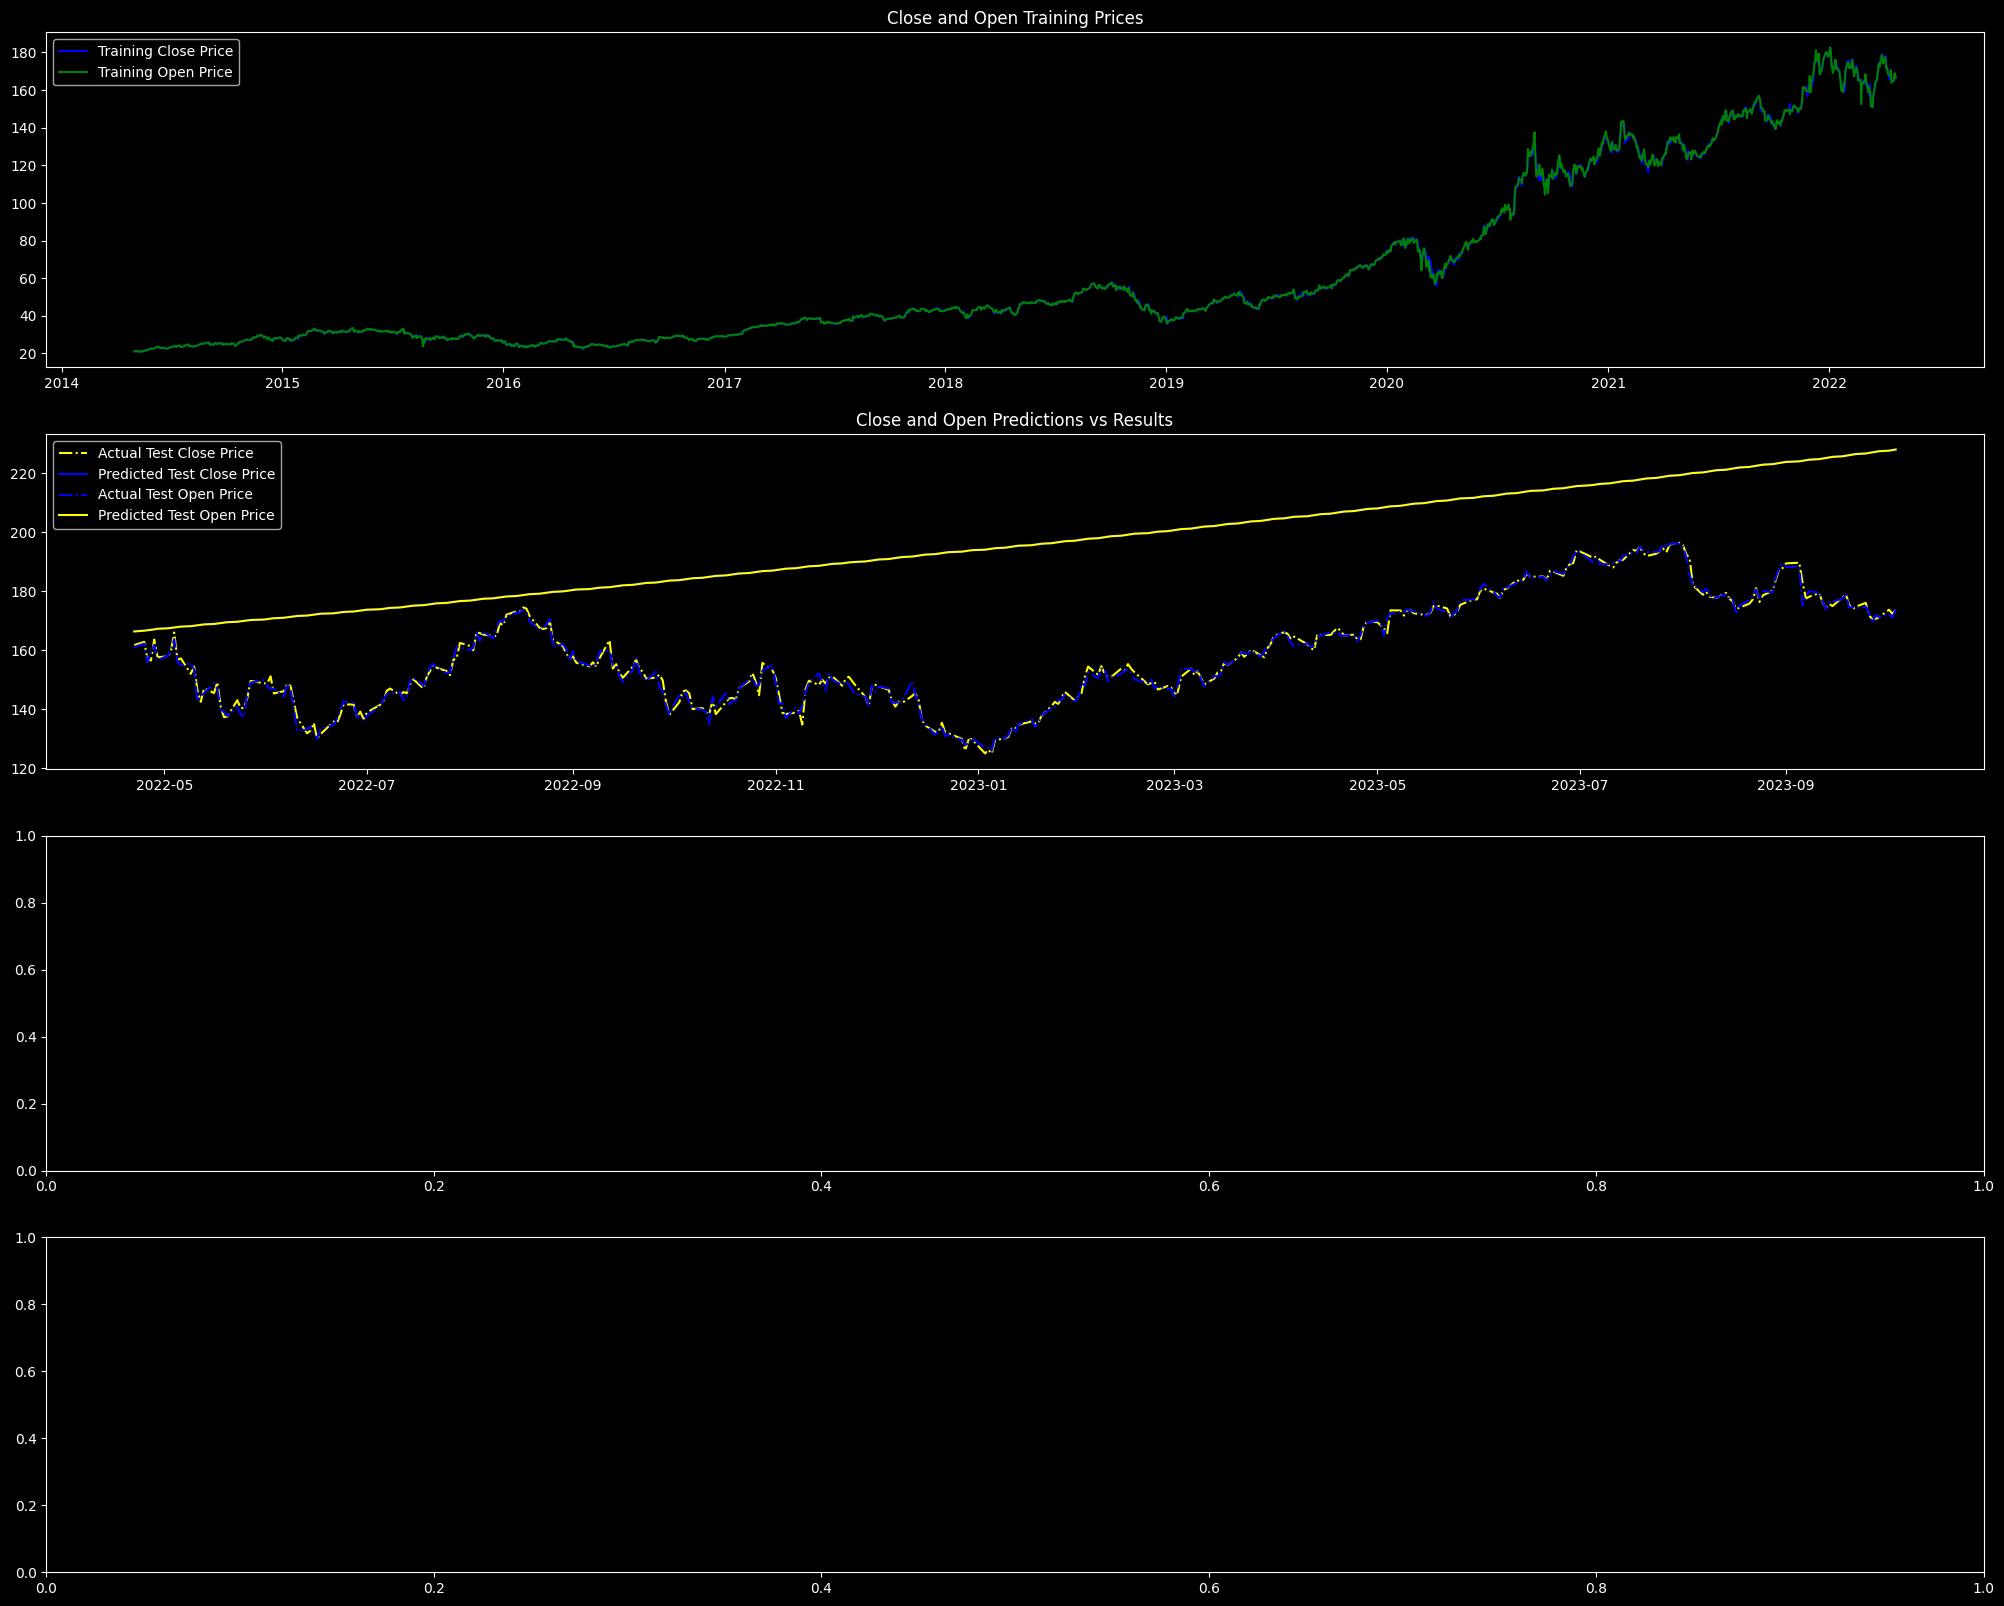

In [83]:
prediction.graph()